In [10]:
import pandas as pd
SPFULL = pd.read_csv("daily_SNP_full.csv")
# SPFULL = df.iloc[::-1].reset_index(drop=False)
print(SPFULL.head())
print(SPFULL.tail())



         Date      Open      High      Low     Close   Volume      RSI  SMA10  \
0  1999-11-19  142.4062  142.9687  142.000  142.5000  4832100  79.5996    NaN   
1  1999-11-22  142.4375  143.0000  141.500  142.4687  4155400  79.3713    NaN   
2  1999-11-23  142.8437  142.8437  140.375  141.2187  5918000  70.6558    NaN   
3  1999-11-24  140.7500  142.4375  140.000  141.9687  4459700  72.5999    NaN   
4  1999-11-26  142.4687  142.8750  141.250  141.4375  1693900  69.1077    NaN   

   SMA20  SMA50  SMA200  
0    NaN    NaN     NaN  
1    NaN    NaN     NaN  
2    NaN    NaN     NaN  
3    NaN    NaN     NaN  
4    NaN    NaN     NaN  
            Date     Open      High     Low   Close    Volume      RSI  \
6316  2024-12-30  587.890  591.7400  584.41  588.22  56578757  43.2962   
6317  2024-12-31  589.905  590.6399  584.42  586.08  57052654  41.5771   
6318  2025-01-02  589.390  591.1300  580.50  584.64  50203975  40.4142   
6319  2025-01-03  587.530  592.6000  586.43  591.95  37888459

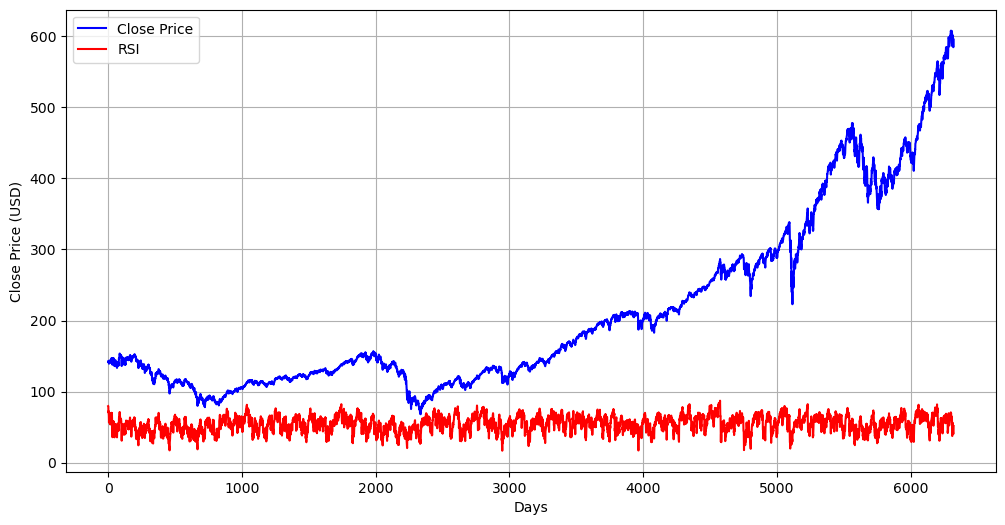

In [11]:
import matplotlib.pyplot as plt
# Plot the "close" prices
plt.figure(figsize=(12, 6))
plt.plot(SPFULL['Close'], label='Close Price', color='blue')
plt.plot(SPFULL['RSI'], label='RSI', color='red')
# plt.plot(SPSMA['SMA10'], label="SMA10", color="red")
# plt.plot(SPSMA['SMA20'], label="SMA10", color="yellow")
# plt.plot(SPSMA['SMA50'], label="SMA10", color="green")
# plt.plot(SPSMA['SMA200'], label="SMA10", color="pink")
# plt.plot(SP20['SMA'], label="SMA20", color="yellow")
# plt.plot(SP50['SMA'], label="SMA50", color="yellow")
# plt.plot(SP200['SMA'], label="SMA200", color="yellow")
# plt.title('SPY close vs SMA of various durations')
plt.xlabel('Days')
plt.ylabel('Close Price (USD)')
plt.legend()
plt.grid()
plt.show()

In [14]:
MIN_RSI = 35
MAX_RSI = 70
TP = 0.15  # Take profit: 15%
SL = 0.05  # Stop loss: 5%

# Initialize variables for logging results
profit_loss_log = []
open_positions = []
df = pd.read_csv("daily_SNP_full.csv")
# df = df.iloc[::-1].reset_index(drop=True)

# Iterate through data
for i, row in df.iterrows():
    close_price = row["Close"]
    rsi = row["RSI"]

    # Check open positions
    updated_positions = []
    for position in open_positions:
        if position["type"] == "LONG":
            tp_price = position["entry"] * (1 + TP)
            sl_price = position["entry"] * (1 - SL)
            if close_price >= tp_price or rsi>MAX_RSI:
                profit_loss_log.append((tp_price - position["entry"])/position["entry"]*100)
            elif close_price <= sl_price or rsi>MAX_RSI:
                profit_loss_log.append((sl_price - position["entry"])/position["entry"]*100)
            else:
                updated_positions.append(position)
        elif position["type"] == "SHORT":
            tp_price = position["entry"] * (1 - TP)
            sl_price = position["entry"] * (1 + SL)
            if close_price <= tp_price or rsi>MIN_RSI:
                profit_loss_log.append((position["entry"] - tp_price)/position["entry"]*100)
            elif close_price >= sl_price or rsi>MIN_RSI:
                profit_loss_log.append((position["entry"] - sl_price)/position["entry"]*100)
            else:
                updated_positions.append(position)

    open_positions = updated_positions

    if rsi < MIN_RSI:
        open_positions.append({"type": "LONG", "entry": close_price})
    elif rsi > MAX_RSI:
        open_positions.append({"type": "SHORT", "entry": close_price})


In [15]:
MIN_RSI = 35
MAX_RSI = 70
TP = 0.15  # Take profit: 10%
SL = 0.05  # Stop loss: 5%

# Initialize variables for logging results
profit_loss_log = []
trade_log = []
open_positions = []
total_trades = 0
winning_trades = 0
time_in_trades = []

# Open log file
with open("trade_log.txt", "w") as log_file:
    log_file.write("Trade Log\n")
    log_file.write("=" * 40 + "\n")

    # Iterate through data
    for i, row in df.iterrows():
        close_price = row["Close"]
        rsi = row["RSI"]
        current_date = row["Date"]  # Assuming a 'date' column in the DataFrame

        # Check open positions
        updated_positions = []
        for position in open_positions:
            entry_price = position["entry"]
            if position["type"] == "LONG":
                tp_price = position["entry"] * (1 + TP)
                sl_price = position["entry"] * (1 - SL)
                if close_price >= tp_price or close_price <= sl_price or rsi>MAX_RSI:
                    # Calculate profit/loss
                    
                    result = ((close_price-entry_price)/entry_price)*100
                    profit_loss_log.append(result)
                    trade_log.append(
                        f"Trade {total_trades + 1}: Entered LONG @ {position['entry']} on {position['entry_date']} "
                        f"and EXITED @ {close_price} on {current_date} for a profit/loss of {result:.2f}%\n"
                    )
                    log_file.write(trade_log[-1])
                    total_trades += 1
                    if result > 0:
                        winning_trades += 1
                else:
                    updated_positions.append(position)
            elif position["type"] == "SHORT":
                tp_price = position["entry"] * (1 - TP)
                sl_price = position["entry"] * (1 + SL)
                if close_price <= tp_price or close_price >= sl_price or rsi>MIN_RSI:
                    # Calculate profit/loss
                    result = ((close_price-entry_price)/entry_price)*-100
                    profit_loss_log.append(result)
                    trade_log.append(
                        f"Trade {total_trades + 1}: Entered SHORT @ {position['entry']} on {position['entry_date']} "
                        f"and EXITED @ {close_price} on {current_date} for a profit/loss of {result:.2f}%\n"
                    )
                    log_file.write(trade_log[-1])
                    total_trades += 1
                    if result > 0:
                        winning_trades += 1
                else:
                    updated_positions.append(position)

        open_positions = updated_positions

        # Check for new trades
        if rsi < MIN_RSI:
            open_positions.append(
                {"type": "LONG", "entry": close_price, "entry_date": current_date}
            )
        elif rsi > MAX_RSI:
            open_positions.append(
                {"type": "SHORT", "entry": close_price, "entry_date": current_date}
            )

    # Calculate and log statistics
    win_rate = (winning_trades / total_trades) * 100 if total_trades > 0 else 0

    log_file.write("\nSummary Statistics\n")
    log_file.write("=" * 40 + "\n")
    log_file.write(f"Total Trades: {total_trades}\n")
    log_file.write(f"Win Rate: {win_rate:.2f}%\n")
    log_file.write(f"Total Profit/Loss: {sum(profit_loss_log):.2f}%\n")

# Console outputs
print(f"Total Trades: {total_trades}")
print(f"Win Rate: {win_rate:.2f}%")
print(f"Total Profit/Loss: {sum(profit_loss_log):.2f}%")
print(profit_loss_log)


Total Trades: 811
Win Rate: 48.83%
Total Profit/Loss: 669.42%
[0.021964912280692944, 0.877385699455389, -0.5310911373635361, 0.37416698187700004, 0.7386489641186927, 0.13864967098861644, 0.11708812260535972, -0.593686990767481, 1.0582010582010581, -6.701708278580814, -5.571965501588738, -7.169117647058823, -7.530293442085041, -5.164319248826291, -6.307977736549166, -5.95903165735568, -5.434060387193649, -6.471287128712873, -6.002228944435604, -6.144185676814247, -5.505761843790009, -5.232744783306578, -5.082694634933438, -6.957365908907041, -6.465589068488578, -5.894308943089426, -5.550361240968976, -5.574439157036031, -5.308904985087337, 15.091946734305642, 16.04571634269257, 15.045430251202566, 14.46830710373011, 15.280210157618216, 0.12913026965439872, -6.955060898782025, -6.333502452223922, -6.428450751816185, -7.959759971761381, -5.840931660196803, -5.224897773739209, -6.227005150846207, -5.359539789069994, -5.132148005766462, 15.54276315789474, 16.04700638233209, 15.1241310824230